<a href="https://colab.research.google.com/github/Akila-Ayanthi/Text2FaceGeneration-/blob/main/TextToFaceModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


Setting up BERT Server

In [2]:
!pip3 install virtualenv
!virtualenv myenv
!source /content/myenv/bin/activate myenv; pip install tensorflow==1.14; pip install bert-serving-server; wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip; unzip uncased_L-12_H-768_A-12.zip; nohup bert-serving-start -max_seq_len=128 -model_dir=uncased_L-12_H-768_A-12 > out.file 2>&1 &

OSError: Background processes not supported.

created virtual environment CPython3.6.13.final.0-64 in 5858ms
  creator CPython3Windows(dest=C:\Users\ASUS\Text2FaceGeneration-main\myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=C:\Users\ASUS\AppData\Local\pypa\virtualenv)
    added seed packages: pip==21.3.1, setuptools==59.6.0, wheel==0.37.1
  activators BashActivator,BatchActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [3]:
!pip install bert-serving-client

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


StyleGAN2

In [5]:
!git clone https://github.com/Akila-Ayanthi/StyleGAN2-TensorFlow-2.x.git

Cloning into 'StyleGAN2-TensorFlow-2.x'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 93 (delta 2), reused 0 (delta 0), pack-reused 87
Unpacking objects: 100% (93/93), done.


In [6]:
import sys
sys.path.append('/content/StyleGAN2-TensorFlow-2.x')

In [7]:
!mkdir weights

In [8]:
import os
os.system('cmd /c "pip install gdown"')

import gdown
    
file_id = ['1afMN3e_6UuTTPDL63WHaA0Fb9EQrZceE', '1drwB9iHfxpQy8tr59R2J9tQxzNrhEfw4']

name = ['ffhq.npy', 'ffhq_dlatent_avg.npy']


weight_dir = 'weights/'
for i in range(len(name)):
    output = weight_dir + name[i]
    url = "https://drive.google.com/uc?id={}".format(file_id[i])
    gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1afMN3e_6UuTTPDL63WHaA0Fb9EQrZceE
To: /content/weights/ffhq.npy
100%|██████████| 249M/249M [00:01<00:00, 212MB/s]
Downloading...
From: https://drive.google.com/uc?id=1drwB9iHfxpQy8tr59R2J9tQxzNrhEfw4
To: /content/weights/ffhq_dlatent_avg.npy
100%|██████████| 2.18k/2.18k [00:00<00:00, 4.11MB/s]


In [9]:
from stylegan2 import StyleGan2
from stylegan2_generator import StyleGan2Generator
from bert_serving.client import BertClient
from keras.models import load_model

In [23]:
impl = 'ref' # 'ref' if cuda is not available in your machine
gpu = True # False if tensorflow cpu is used

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Input, InputLayer, Lambda, Flatten, Softmax, LeakyReLU, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.activations import tanh
from sklearn.metrics import classification_report
import numpy as np
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from csv import reader
import tensorflow.keras.backend as K
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img, save_img
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.callbacks import CSVLogger
# from utils.utils_stylegan2 import convert_images_to_uint8


Data Path

In [13]:
# Data
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset'
BASE_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/'   #descriptions


In [15]:
train_descs = pd.read_csv(BASE_CSV_PATH+'train_desc.csv')
train_set = pd.read_csv(BASE_CSV_PATH+'5000_train_images1.csv', header=None)
# train_image_ids = train_set[0]
# train_descs = train_descs.drop(['Unnamed: 0'], axis = 1)
# train_descs["description"]= train_descs["description"].str.replace('|', " ")

In [16]:
#BERT Client
bc = BertClient()
bc1 = BertClient()

In [18]:
#preprocessing 
def _preprocess_numpy_input(x, data_format, mode, **kwargs):
    """Preprocesses a Numpy array encoding a batch of images.
    # Arguments
        x: Input array, 3D or 4D.
        data_format: Data format of the image array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        Preprocessed Numpy array.
    """
    # backend, _, _, _ = get_submodules_from_kwargs(kwargs)
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(K.floatx(), copy=False)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if x.ndim == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
        #for 5000 images
        mean = [98.5532, 109.2222, 129.6560]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] -= mean[0]
            x[1, :, :] -= mean[1]
            x[2, :, :] -= mean[2]
            if std is not None:
                x[0, :, :] /= std[0]
                x[1, :, :] /= std[1]
                x[2, :, :] /= std[2]
        else:
            x[:, 0, :, :] -= mean[0]
            x[:, 1, :, :] -= mean[1]
            x[:, 2, :, :] -= mean[2]
            if std is not None:
                x[:, 0, :, :] /= std[0]
                x[:, 1, :, :] /= std[1]
                x[:, 2, :, :] /= std[2]
    else:
        x[..., 0] -= mean[0]
        x[..., 1] -= mean[1]
        x[..., 2] -= mean[2]
        if std is not None:
            x[..., 0] /= std[0]
            x[..., 1] /= std[1]
            x[..., 2] /= std[2]
    return x


def _preprocess_symbolic_input(x, data_format, mode, **kwargs):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: Input tensor, 3D or 4D.
        data_format: Data format of the image tensor.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        Preprocessed tensor.
    """

    # backend, _, _, _ = get_submodules_from_kwargs(kwargs)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if K.ndim(x) == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
        #mean for 5000 images
        mean = [98.5532, 109.2222, 129.6560]
        std = None

    mean_tensor = K.constant(-np.array(mean))

    # Zero-center by mean pixel
    if K.dtype(x) != K.dtype(mean_tensor):
        x = K.bias_add(
            x, K.cast(mean_tensor, K.dtype(x)),
            data_format=data_format)
    else:
        x = K.bias_add(x, mean_tensor, data_format)
    if std is not None:
        x /= std
    return x


def preprocess_input(x, data_format=None, mode='caffe', **kwargs):
    """Preprocesses a tensor or Numpy array encoding a batch of images.
    # Arguments
        x: Input Numpy or symbolic tensor, 3D or 4D.
            The preprocessed data is written over the input data
            if the data types are compatible. To avoid this
            behaviour, `numpy.copy(x)` can be used.
        data_format: Data format of the image tensor/array.
        mode: One of "caffe", "tf" or "torch".
            - caffe: will convert the images from RGB to BGR,
                then will zero-center each color channel with
                respect to the ImageNet dataset,
                without scaling.
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
    # Returns
        Preprocessed tensor or Numpy array.
    # Raises
        ValueError: In case of unknown `data_format` argument.
    """
    # backend, _, _, _ = get_submodules_from_kwargs(kwargs)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(x, data_format=data_format,
                                       mode=mode, **kwargs)
    else:
        return _preprocess_symbolic_input(x, data_format=data_format,
                                          mode=mode, **kwargs)

## LossModel with Hypercolumn

In [ ]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg_model.trainable = False
# vgg_model.summary()

for layer in vgg_model.layers:
  layer.trainable=False

selectedLayers = [13, 17]
layers = [vgg_model.layers[li].output for li in selectedLayers]
get_feature = K.function([vgg_model.layers[0].input],layers)
for layer in layers:  
    print(layer.name)

feature_maps = get_feature(vgg_model.inputs)
print(type(feature_maps))
hypercolumns = []
for convmap in feature_maps:
  conv_out = convmap[0, :, :, :]
  feat_map = tf.transpose(conv_out, perm = [2, 0, 1])
  
  print("F sz :",feat_map.shape)
  for fmap in feat_map: 
    fmap = tf.expand_dims(fmap, axis = 0)
    fmap = tf.transpose(fmap, perm=[1, 2, 0])
    upscaled = tf.image.resize(fmap, [224, 224])
    hypercolumns.append(upscaled)

hc1 = tf.convert_to_tensor(hypercolumns)
hc1 = tf.transpose(hc1, perm=[1, 2, 0, 3])
hc1 = K.reshape(hc1, (224*224, -1))

LossModel1 = Model(vgg_model.inputs, hc1)

block4_conv2/Relu:0
block5_conv2/Relu:0
<class 'list'>
F sz : (512, 28, 28)
F sz : (512, 14, 14)


In [19]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg_model.trainable = False

for layer in vgg_model.layers:
  layer.trainable=False

selectedLayers = [2, 5, 8, 13]
# print(vgg_model.get_layer(index = 9))
selectedOutputs = [vgg_model.layers[i].output for i in selectedLayers]

LossModel1 = Model(vgg_model.inputs, selectedOutputs)
# LossModel1.summary()

58900480/58889256 [==============================] - 2s 0us/step


In [20]:
def convert_images_to_uint8(images, drange=[-1, 1], nchw_to_nhwc=True, shrink=1, uint8_cast=True):
    """Convert a minibatch of images from float32 to uint8 with configurable dynamic range.
    Can be used as an output transformation for Network.run().
    """
    images = tf.cast(images, tf.float32)
    if shrink > 1:
        ksize = [1, 1, shrink, shrink]
        images = tf.nn.avg_pool(images, ksize=ksize, strides=ksize, 
                                padding="VALID", data_format="NCHW")
    if nchw_to_nhwc:
        images = tf.transpose(images, [0, 2, 3, 1])
    # scale = 255 / (drange[1] - drange[0])
    # images = images * scale + (0.5 - drange[0] * scale)
    if uint8_cast:
        images = tf.saturate_cast(images, tf.uint8)
    return images

Text2Face Model

In [21]:
def TextToFaceModel():

  weights_name = 'ffhq' # face model trained by Nvidia
  gen = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)
  gen.trainable = False

  input = Input(shape=(768,))
  x = Dense(2304)(input)
  x = Dense(4608)(x)
  x = Dense(9216)(x)
  out = Reshape((18, 512))(x)



  out_ = gen.synthesis_network(out)
  out_ = tf.transpose(out_, perm = [0, 2, 3, 1])

  img = tf.image.resize(out_, (224, 224))
  img = preprocess_input(img)

  lossModelOutputs = LossModel1(img)

  FullModel = Model(input, [lossModelOutputs[0], lossModelOutputs[1], lossModelOutputs[2], lossModelOutputs[3]])
 
  plot_model(FullModel, to_file="demo.png", show_shapes=True, show_layer_names=True)

  FullModel.summary()

  return FullModel
  

In [ ]:
def train_data_generator(csv_file, batch_size, descs):
  while 1:
    # print(csv_files)
    
    m = 0
    data = pd.read_csv(BASE_PATH+csv_file, header=None)
    data = data.sample(frac=1)
    for t in range(int(len(data)/batch_size)):
      temp_data = data[m:m+batch_size]
      m = m+batch_size

      X, y0, y1, y2, y3 = [], [], [], [], []

      for index, row in temp_data.iterrows():
        image_id = row.iloc[0]
        arr_path = row.iloc[1]
        image = Image.open(arr_path)
        image = image.resize((224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        lossModelOutputs = LossModel1(image)
  
        y0.append(np.squeeze(lossModelOutputs[0], axis = 0))
        y1.append(np.squeeze(lossModelOutputs[1], axis = 0))
        y2.append(np.squeeze(lossModelOutputs[2], axis = 0))
        
        row1 = descs.loc[descs['Image_id'] == image_id]
        desc = row1['Caption'].values
        embds = bc.encode([desc[0]])
        embds = np.squeeze(embds)
        X.append(embds)
      
      X = tf.convert_to_tensor(X)
      y0 = tf.convert_to_tensor(y0)
      y1 = tf.convert_to_tensor(y1)
      y2 = tf.convert_to_tensor(y2)
      yield X, [y0, y1, y2]


In [ ]:
def train():
  batch_size = 8
  # learning_rate = 0.1 
  epochs = 500
  
  K.clear_session()
  model = TextToFaceModel()

  model.load_weights('/content/drive/MyDrive/Colab Notebooks/Modelv2/models/model_45_latent/495-109105.01')

  #Prepare train generator
  train_gen = train_data_generator('/5000_train_images1.csv', batch_size, train_descs)

  opt = Adam(learning_rate = 0.0001)
  loss = mean_squared_error
  model.compile(optimizer = opt, loss = loss)

  filepath = '/content/drive/MyDrive/Colab Notebooks/Modelv2/models/' + "model_45_latent/{epoch:02d}-{loss:.2f}"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
    monitor="loss", 
    verbose=1, 
    save_best_only=True, mode="min")
  
  csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Modelv2/models/model_45_latent/training.log', separator=',', append=True)

  
  _ = model.fit(train_gen,
                epochs=epochs, 
                steps_per_epoch = len(train_image_ids)//batch_size,
                shuffle = True,
                callbacks=[checkpoint_callback, csv_logger], initial_epoch = 495)  

  model.save('/content/drive/MyDrive/Colab Notebooks/Modelv2/models/model_45_latent/model5')

train()



Load Model 

In [24]:
model = TextToFaceModel()
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Modelv2/models/model_45_latent/450-109813.70')
opt = Adam(learning_rate=0.0001)
loss1 = tf.keras.losses.mean_squared_error
model.compile(optimizer = opt, loss = loss1)
layer_name = 'Synthesis_network'
intermediate_layer_model = Model(inputs= model.input, outputs = model.get_layer(layer_name).output)

Loaded ffhq generator weights!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 2304)              1771776   
                                                                 
 dense_1 (Dense)             (None, 4608)              10621440  
                                                                 
 dense_2 (Dense)             (None, 9216)              42476544  
                                                                 
 reshape (Reshape)           (None, 18, 512)           0         
                                                                 
 Synthesis_network (Synthesi  (None, 3, 1024, 1024)    28268812  
 sNetwork)                                                       
                            

Testing model

In [26]:
embds1 = bc.encode(["The chubby double chined woman has high cheekbones. She has a receding hairline. She has big lips and big nose with arched eyebrows. The smiling, young woman has heavy makeup. She's wearing earrings and lipstick."])
embds2 = bc.encode(["The chubby double chined man has high cheekbones. He is bald. He has big nose and a slightly open mouth. The man is smiling. He's wearing necktie."])
embds3 = bc.encode(["The woman has high cheekbones. She has wavy hair which is blond in colour. She has pointy nose with arched eyebrows. The smiling, young attractive woman has rosy cheeks and heavy makeup. She's wearing lipstick."])
embds4 = bc.encode(["The man has oval face and high cheekbones. He sports a 5 o'clock shadow, a goatee and mustache. He has straight hair which is black in colour. He has big nose, narrow eyes with arched eyebrows and a slightly open mouth. The young attractive man is smiling."])

embds1 = np.squeeze(embds1)
embds2 = np.squeeze(embds2)
embds3 = np.squeeze(embds3)
embds4 = np.squeeze(embds4)

embd = []

embd.append(embds1)
embd.append(embds2)
embd.append(embds3)
embd.append(embds4)

embd = tf.convert_to_tensor(embd)

pred1 = intermediate_layer_model.predict(embd)

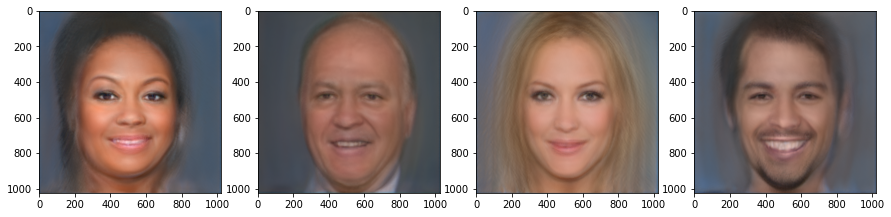

In [27]:
# from utils.utils_stylegan2 import convert_images_to_uint8

img1 = convert_images_to_uint8(np.expand_dims(pred1[0], axis = 0), nchw_to_nhwc=True, uint8_cast=True)
img2 = convert_images_to_uint8(np.expand_dims(pred1[1], axis = 0), nchw_to_nhwc=True, uint8_cast=True)
img3 = convert_images_to_uint8(np.expand_dims(pred1[2], axis = 0), nchw_to_nhwc=True, uint8_cast=True)
img4 = convert_images_to_uint8(np.expand_dims(pred1[3], axis = 0), nchw_to_nhwc=True, uint8_cast=True)

fig, ax = plt.subplots(1,4,figsize=(15,15))
img_plot = ax[0].imshow(img1.numpy()[0])
img_plot = ax[1].imshow(img2.numpy()[0])
img_plot = ax[2].imshow(img3.numpy()[0])
img_plot = ax[3].imshow(img4.numpy()[0])

In [ ]:
test_data_images = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/1000_test_aligned_celeb_images.csv', header= None)
test_descriptions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/test_desc.csv')

Generate Images

In [ ]:
# from utils.utils_stylegan2 import convert_images_to_uint8

for index, row in test_data_images.iterrows():
  image_id = row.iloc[0]
  arr_path = row.iloc[1]

  row1 = test_descriptions.loc[test_descriptions['Image_id'] == image_id]
  desc = row1['Caption'].values
  embds = bc.encode([desc[0]])

  embds = np.expand_dims(embds, axis = 0)
  pred = intermediate_layer_model2.predict(embds[0])
  img = convert_images_to_uint8(pred, nchw_to_nhwc=True, uint8_cast=True)
  save_img('/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500_ckpt/gen_{}'.format(image_id), img[0], data_format=None, file_format=None, scale=True)
  


FID Score

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  
  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
    # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
 
  return fid

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

gen_image_dir = '/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500_ckpt'
images_ = os.listdir(gen_image_dir)
generated_images = []
gen, real = [], []
fid_score = [] 
for image in images_:
  generated_images.append(image.replace("gen_", ""))

for image in generated_images:
  path = test_data_images.loc[test_data_images[0]==image, 1].iloc[0]
  real_image = Image.open(path)
  real_image = real_image.resize((299, 299))
  real_image = img_to_array(real_image)
  real_image = preprocess_input(real_image)
  real.append(real_image)

  gen_image = Image.open(gen_image_dir+'/gen_'+image)
  gen_image = gen_image.resize((299, 299))
  gen_image = img_to_array(gen_image)
  gen_image = preprocess_input(gen_image)
  gen.append(gen_image)

# print(asarray(gen).shape)
fid = calculate_fid(model, asarray(real), asarray(gen))
# # fid_score.append(fid)
print('FID: %.3f' % fid)

FID: 118.097


Face Semantic Distance and Face Semantic Similarity

In [ ]:
!pip install deepface #install the Deepface Library

     |████████████████████████████████| 61 kB 2.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 5.3 MB/s 
  Created wheel for gdown: filename=gdown-4.0.2-py3-none-any.whl size=10613 sha256=e1fa052eb637cb8218d6f0c5d0c7947ecb9058e811063ee957e3fb89557b7155
  Stored in directory: /root/.cache/pip/wheels/75/20/08/4d138cf98df8fe9e14e369c7de79e01c5cabca55b0f58cef3a
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt 
import pandas as pd

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
img1_path = '/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/selected_celeba/1000_test_aligned/051404_01.png'
img2_path = '/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_300/gen_051404_01.png'
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path) 

In [ ]:
plt.imshow(img1[:, :, ::-1 ]) #setting value as -1 to maintain saturation
plt.show()
plt.imshow(img2[:, :, ::-1 ]) 
plt.show() 

In [ ]:
#calling the model
model_name = 'VGG-Face'
#creating a function named resp to store the result
# resp = DeepFace.verify(img1_path = img1_path , img2_path = img2_path, model_name = model_name, enforce_detection=True, distance_metric='cosine', detector_backend='mtcnn', normalization='VGGFace')
# resp #generating our result 

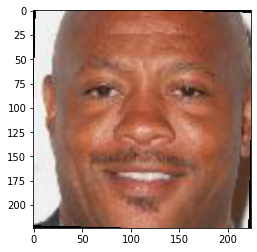

In [ ]:
img11 = DeepFace.detectFace(img1_path)
plt.imshow(img11)
save_img('img3.png', img11, scale = True)

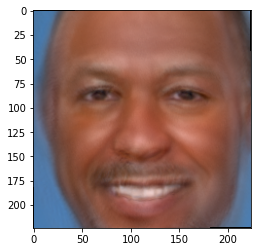

In [ ]:
img12 = DeepFace.detectFace(img2_path)
plt.imshow(img12)
save_img('img2.png', img12, scale = True)

In [ ]:
gen_image_dir = '/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500'
images_ = os.listdir(gen_image_dir)
generated_images = []
print(len(images_))
for image in images_:
  generated_images.append(image.replace("gen_", ""))
  
cosine_similarity, csd=[], []
ec_distance=[]
i =0
for image in generated_images:
  print(i)
  print(image)
  i=i+1
  real_path = test_data_images.loc[test_data_images[0]==image, 1].iloc[0]
  print(real_path)

  gen_path = gen_image_dir+'/gen_'+image 
  print(gen_path)

  resp = DeepFace.verify(img1_path = real_path , img2_path = gen_path, model_name = model_name, enforce_detection=False, distance_metric='euclidean_l2', detector_backend='mtcnn', normalization='VGGFace')
  # cosine_similarity.append(1-resp['distance']) #generating our result 
  ec_distance.append(resp['distance'])
    


1000
0
055127_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/selected_celeba/1000_test_aligned/055127_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500/gen_055127_01.png
1
054575_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/selected_celeba/1000_test_aligned/054575_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500/gen_054575_01.png
2
054873_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/selected_celeba/1000_test_aligned/054873_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500/gen_054873_01.png
3
054466_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/selected_celeba/1000_test_aligned/054466_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Generated Images/model_45_latent_2_500/gen_054466_01.png
4
053654_01.png
/content/drive/MyDrive/Colab Notebooks/Modelv2/Dataset/selected_celeba/1000_test_aligne

In [ ]:
# cs = np.average(cosine_similarity)
# cddd = np.average(ed)
ec = np.average(ec_distance)